In [1]:
import geopandas as gpd
import pandas as pd
import math
from tqdm import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.patheffects as pe
import seaborn as sns
from scipy.cluster import hierarchy
import esda
import libpysal

# Proposed framework: Leveraging temporal changes of spatial accessibility measurements for better policy implications

![title](figure1.jpg)

# 1. Data Preparation
## 1.1. Load inputs

### Supply
EV charging stations located in Seoul, South Korea <br>
Source: Korea Environment Corporation EV Monitor. https://www.ev.or.kr/evmonitor.
### Demand
Floating population over 24 hours <br>
Source: Seoul Open Data Plaza - Floating Population. https://data.seoul.go.kr/dataVisual/seoul/seoulLivingPopulation.do.
### Mobility
Estimated travel time from demand locations to supply location <br>
Source: iNavi Maps API. https://docs.toast.com/en/Application%20Service/Maps/en/Overview/

Text(0.5, 0.9, 'Distribution of floating population over 24 hours')

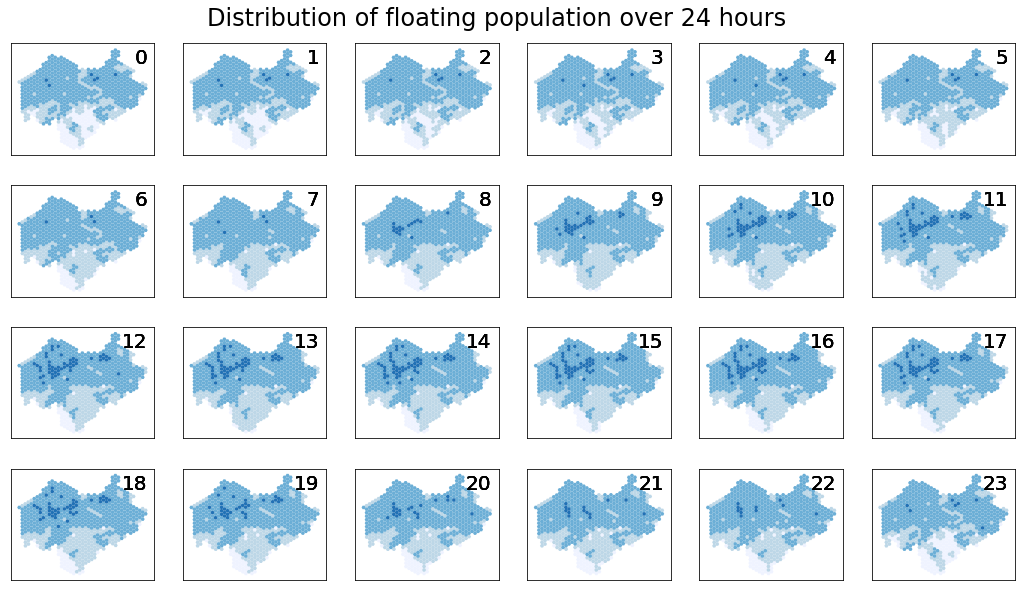

In [2]:
# Loading DEMAND data
demand = gpd.read_file('./data/demand.shp')
demand = demand.set_index('GRID_ID')
demand['dummy'] = 'dummy'
study_area = demand.dissolve(by='dummy')

# Plotting the distribution of floating population over 24 hours.
fig = plt.figure(figsize=(18, 10))
colorBrewer = ['#eff3ff', '#bdd7e7', '#6baed6', '#2171b5']
plt_cls = [10, 100, 1000, 10000, 100000]
for qTime in range(24):

    ax = fig.add_subplot(4, 6, qTime + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for idx, cls in enumerate(plt_cls):
        if idx == 0:  
            continue

        temp_hxg = demand.loc[(plt_cls[idx-1] < demand[f'Flo_WD_{qTime}']) & (demand[f'Flo_WD_{qTime}'] <= cls)]
        if temp_hxg.shape[0] > 0:
            temp_hxg.plot(ax=ax, color=colorBrewer[idx-1])

        ax.text(0.95, 0.95, str(qTime), fontsize=20, ha='right', va='top', transform=ax.transAxes)
        
fig.text(0.5, 0.9, 'Distribution of floating population over 24 hours', ha='center', size=24)

Text(0.5, 0.9, 'Locations and weights of operating EV charging stations over 24 hours')

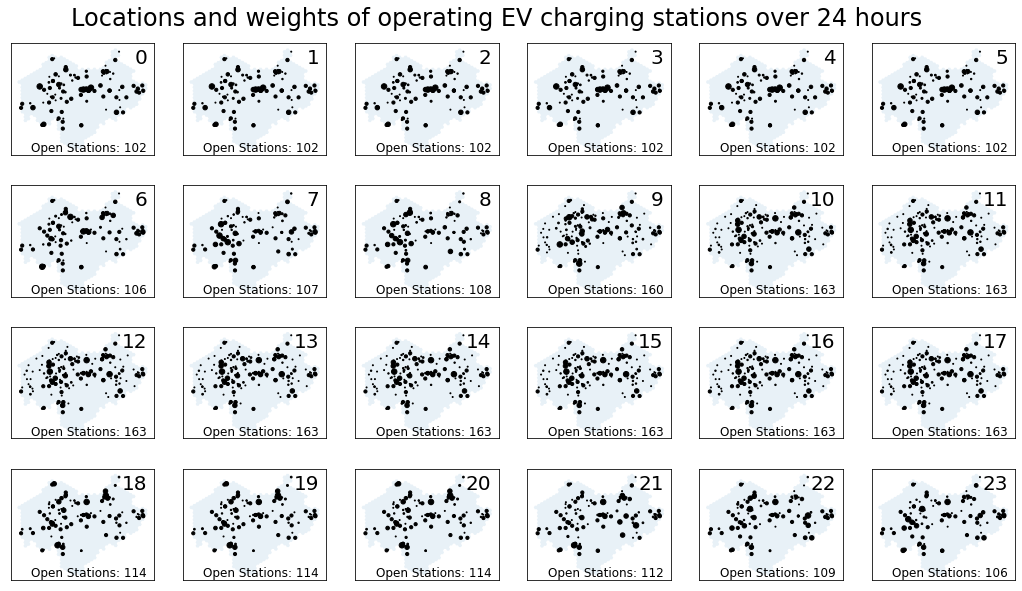

In [3]:
# Loading SUPPLY data
supply = gpd.read_file('./data/supply.shp')
supply = supply.set_index('StationID')

# Plot the changes in the degree of supply over 24 hours
fig = plt.figure(figsize=(18, 10))

for qTime in range(24):

    ax = fig.add_subplot(4, 6, qTime + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    study_area.plot(alpha=0.1, ax=ax)
    supply.loc[supply[f'Hour_WD_{qTime}'] == 'Y'].plot(ax=ax, markersize=supply['Weight'], color='black')
    
    ax.text(0.95, 0.95, str(qTime), fontsize=20, ha='right', va='top', transform=ax.transAxes)
    ax.text(0.95, 0.12, 
            'Open Stations: ' + str(supply.loc[supply[f'Hour_WD_{qTime}'] == 'Y'].shape[0]), 
            fontsize=12, ha='right', va='top', transform=ax.transAxes)
    
fig.text(0.5, 0.9, 'Locations and weights of operating EV charging stations over 24 hours', ha='center', size=24)

Text(0, 0.5, 'Estimated Travel Time (Minutes)')

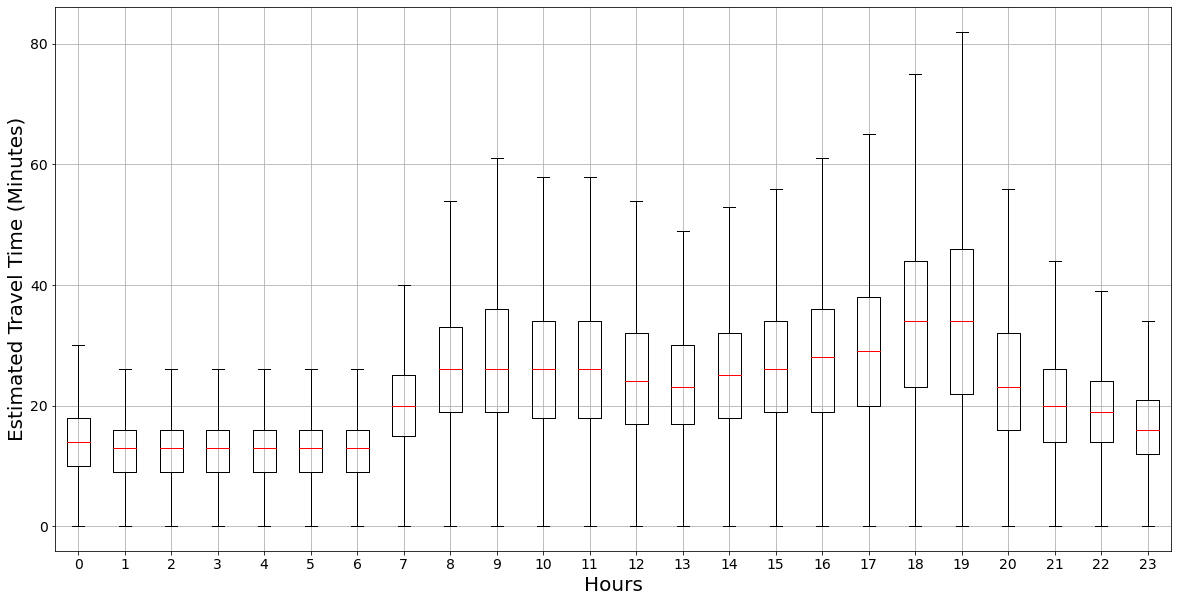

In [4]:
# Loading MOBILITY data
mobility = pd.read_csv('./data/Mobility.csv')
mobility = mobility.loc[mobility['GRID_ID'].isin(demand.index)]

# Plot the changes in the degree of mobility over 24 hours
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
mobility.loc[:, [f'Tra_WD_{qTime}' for qTime in range(0, 24)]].boxplot(
    showfliers=False, fontsize=14, color=dict(boxes='black', whiskers='black', medians='red', caps='black'))
ax.set_xticklabels([f'{qTime}' for qTime in range(24)])
ax.set_xlabel('Hours', fontsize=20)
ax.set_ylabel('Estimated Travel Time (Minutes)', fontsize=20)

## 1.2. Preliminary analysis: determining threshold travel time

In [5]:
accessible_hxg = pd.DataFrame(index=[f't_{qTime}' for qTime in range(24)], columns=[f'thres_{i}' for i in range(0, 31, 1)])
accessible_hxg = accessible_hxg.fillna(0.0)

for qTime in trange(24):

    trvl_time_matrix = pd.DataFrame(index=supply.index, columns=demand.index)
    for grid in demand.index:
        temp_mobility = mobility.loc[mobility['GRID_ID'] == grid][['Station_ID', f'Tra_WD_{qTime}']]
        temp_mobility = temp_mobility.set_index('Station_ID')
        trvl_time_matrix[grid] = temp_mobility

    cum_pop = []
    for threshold_trvl_time in range(0, 31, 1):

        accessible_grid = []
        for grid in demand.index:
            temp_matrix = trvl_time_matrix[grid].loc[trvl_time_matrix[grid] < threshold_trvl_time]
            
            if temp_matrix.shape[0] > 0:
                accessible_hxg.at[f't_{qTime}', f'thres_{threshold_trvl_time}'] += 1
            
        accessible_hxg.at[f't_{qTime}', f'thres_{threshold_trvl_time}'] = accessible_hxg.at[f't_{qTime}', f'thres_{threshold_trvl_time}'] / 703

accessible_hxg

100%|██████████| 24/24 [03:48<00:00,  9.54s/it]


,thres_0,thres_1,thres_2,thres_3,thres_4,thres_5,thres_6,thres_7,thres_8,thres_9,...,thres_21,thres_22,thres_23,thres_24,thres_25,thres_26,thres_27,thres_28,thres_29,thres_30
t_0,0.0,0.091038,0.155050,0.354196,0.603129,0.753912,0.837838,0.866287,0.897582,0.928876,...,0.998578,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t_1,0.0,0.091038,0.176387,0.423898,0.662873,0.799431,0.856330,0.889047,0.918919,0.945946,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t_2,0.0,0.093883,0.179232,0.422475,0.664296,0.799431,0.853485,0.880512,0.916074,0.944523,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t_3,0.0,0.093883,0.179232,0.421053,0.664296,0.795164,0.853485,0.880512,0.916074,0.944523,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t_4,0.0,0.092461,0.176387,0.416785,0.665718,0.795164,0.854908,0.884780,0.913229,0.945946,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t_5,0.0,0.093883,0.177809,0.419630,0.664296,0.798009,0.854908,0.889047,0.916074,0.948791,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t_6,0.0,0.093883,0.179232,0.418208,0.664296,0.795164,0.854908,0.887624,0.914651,0.944523,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t_7,0.0,0.095306,0.146515,0.257468,0.438122,0.630156,0.735420,0.806543,0.849218,0.881935,...,0.995733,0.995733,0.995733,0.997155,0.998578,0.998578,1.000000,1.000000,1.000000,1.000000
t_8,0.0,0.095306,0.145092,0.233286,0.406828,0.573257,0.689900,0.766714,0.809388,0.844950,...,0.990043,0.990043,0.990043,0.991465,0.995733,0.995733,0.995733,0.995733,0.997155,0.998578
t_9,0.0,0.108108,0.156472,0.257468,0.426743,0.597440,0.716927,0.793741,0.829303,0.864865,...,0.987198,0.987198,0.990043,0.995733,0.997155,0.998578,1.000000,1.000000,1.000000,1.000000


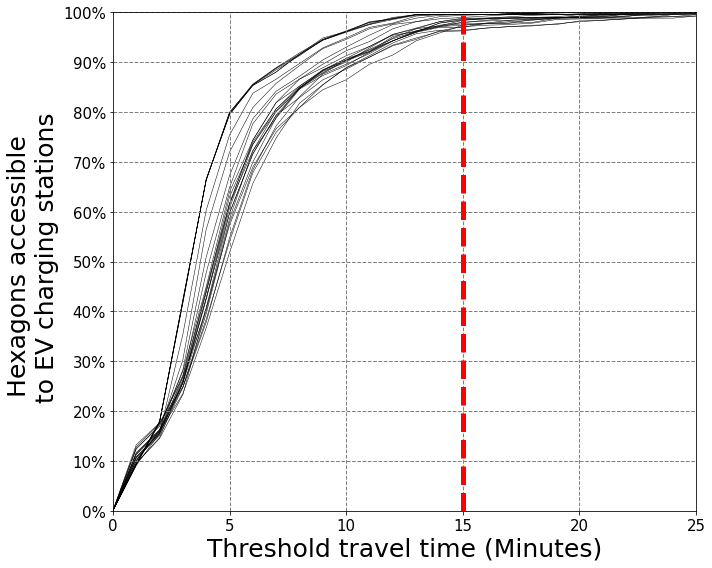

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
accessible_hxg[[f'thres_{i}' for i in range(26)]].transpose().plot(color='black', linewidth=0.5, ax=ax)

for x in range(5, 25, 5):
    plt.axvline(x=x, linewidth='1', linestyle='dashed', color='grey')
for y in range(0, 11, 1):
    plt.axhline(y=y/10, linewidth='1', linestyle='dashed', color='grey')
plt.axvline(x=15, linewidth='5', linestyle='dashed', color='red')
ax.set_ylim(0, 1.001)
ax.set_xlim(0, 25)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels([f'{i}%' for i in range(0, 110, 10)], fontsize=15)
ax.set_xticks([0,5, 10, 15, 20, 25])
ax.set_xticklabels([f'{i}' for i in range(0, 30, 5)], fontsize=15, rotation=0)
ax.set_ylabel(f'Hexagons accessible \n to EV charging stations', fontsize=25)
ax.set_xlabel('Threshold travel time (Minutes)', fontsize=25)
ax.get_legend().remove()
plt.tight_layout()
plt.show()

In [7]:
# Travel time to the nearest EV charging station from each hexagon (represent minimum travel to obtain service)
nearest_trvl_time = pd.DataFrame(index=mobility['GRID_ID'].unique(), columns=[f'WD_{i}' for i in range(24)])

for grid in tqdm(mobility['GRID_ID'].unique()):
    for i in range(24):
        nearest_trvl_time.at[grid, f'WD_{i}'] = mobility.loc[(mobility['GRID_ID'] == grid) & (mobility[f'Tra_WD_{i}'] != 0)][f'Tra_WD_{i}'].min()

# Number of accessible EV charging station per each threshold travel time 
num_of_accessible_supply_5 = pd.DataFrame(index=mobility['GRID_ID'].unique(), columns=[f'WD_{i}' for i in range(24)])
num_of_accessible_supply_10 = pd.DataFrame(index=mobility['GRID_ID'].unique(), columns=[f'WD_{i}' for i in range(24)])
num_of_accessible_supply_15 = pd.DataFrame(index=mobility['GRID_ID'].unique(), columns=[f'WD_{i}' for i in range(24)])
num_of_accessible_supply_20 = pd.DataFrame(index=mobility['GRID_ID'].unique(), columns=[f'WD_{i}' for i in range(24)])
num_of_accessible_supply_25 = pd.DataFrame(index=mobility['GRID_ID'].unique(), columns=[f'WD_{i}' for i in range(24)])

# Average Percentage of accessible EV charging station per each threshold travel time
percent_accessible_supply = pd.DataFrame(index=[f't_{minutes}' for minutes in [5, 10, 15, 20, 25]], columns=[f'WD_{i}' for i in range(24)])

for i in trange(24):
    for grid in mobility['GRID_ID'].unique():
        num_of_accessible_supply_5.at[grid, f'WD_{i}'] = mobility.loc[(mobility['GRID_ID'] == grid) &
                                                                       (mobility[f'Tra_WD_{i}'] <= 5)].shape[0]
        num_of_accessible_supply_10.at[grid, f'WD_{i}'] = mobility.loc[(mobility['GRID_ID'] == grid) &
                                                                       (mobility[f'Tra_WD_{i}'] <= 10)].shape[0]
        num_of_accessible_supply_15.at[grid, f'WD_{i}'] = mobility.loc[(mobility['GRID_ID'] == grid) &
                                                                       (mobility[f'Tra_WD_{i}'] <= 15)].shape[0]
        num_of_accessible_supply_20.at[grid, f'WD_{i}'] = mobility.loc[(mobility['GRID_ID'] == grid) &
                                                                       (mobility[f'Tra_WD_{i}'] <= 20)].shape[0]
        num_of_accessible_supply_25.at[grid, f'WD_{i}'] = mobility.loc[(mobility['GRID_ID'] == grid) &
                                                                       (mobility[f'Tra_WD_{i}'] <= 25)].shape[0]
    percent_accessible_supply.at['t_5', f'WD_{i}'] = num_of_accessible_supply_5[f'WD_{i}'].mean() / supply.shape[0]
    percent_accessible_supply.at['t_10', f'WD_{i}'] = num_of_accessible_supply_10[f'WD_{i}'].mean() / supply.shape[0]
    percent_accessible_supply.at['t_15', f'WD_{i}'] = num_of_accessible_supply_15[f'WD_{i}'].mean() / supply.shape[0]
    percent_accessible_supply.at['t_20', f'WD_{i}'] = num_of_accessible_supply_20[f'WD_{i}'].mean() / supply.shape[0]
    percent_accessible_supply.at['t_25', f'WD_{i}'] = num_of_accessible_supply_25[f'WD_{i}'].mean() / supply.shape[0] 
    
percent_accessible_supply

100%|██████████| 24/24 [09:50<00:00, 24.61s/it]


,WD_0,WD_1,WD_2,WD_3,WD_4,WD_5,WD_6,WD_7,WD_8,WD_9,...,WD_14,WD_15,WD_16,WD_17,WD_18,WD_19,WD_20,WD_21,WD_22,WD_23
t_5,0.0460864,0.0619606,0.0623096,0.0612013,0.0616813,0.0610966,0.0611402,0.0179424,0.0125056,0.0129245,...,0.0135441,0.0131164,0.013387,0.0124357,0.0112751,0.0127586,0.0149578,0.019138,0.0221051,0.0304829
t_10,0.268708,0.347712,0.347765,0.342031,0.346002,0.343288,0.342738,0.107349,0.0657393,0.0653815,...,0.0675458,0.0635925,0.0598661,0.0545689,0.044568,0.04805,0.0828439,0.115133,0.132412,0.181632
t_15,0.608496,0.709117,0.706281,0.698907,0.704815,0.701394,0.699273,0.270907,0.166796,0.170086,...,0.174519,0.165391,0.152406,0.137474,0.107366,0.120221,0.219663,0.302228,0.341874,0.45219
t_20,0.863146,0.929766,0.926398,0.923291,0.927253,0.923117,0.921991,0.515276,0.312622,0.309044,...,0.328723,0.309288,0.284696,0.257032,0.19953,0.215675,0.394828,0.534737,0.589481,0.715976
t_25,0.972126,0.991491,0.991064,0.990706,0.990985,0.99006,0.990051,0.751276,0.495658,0.472489,...,0.500284,0.4696,0.436726,0.400449,0.313843,0.326567,0.576897,0.749627,0.802163,0.893114


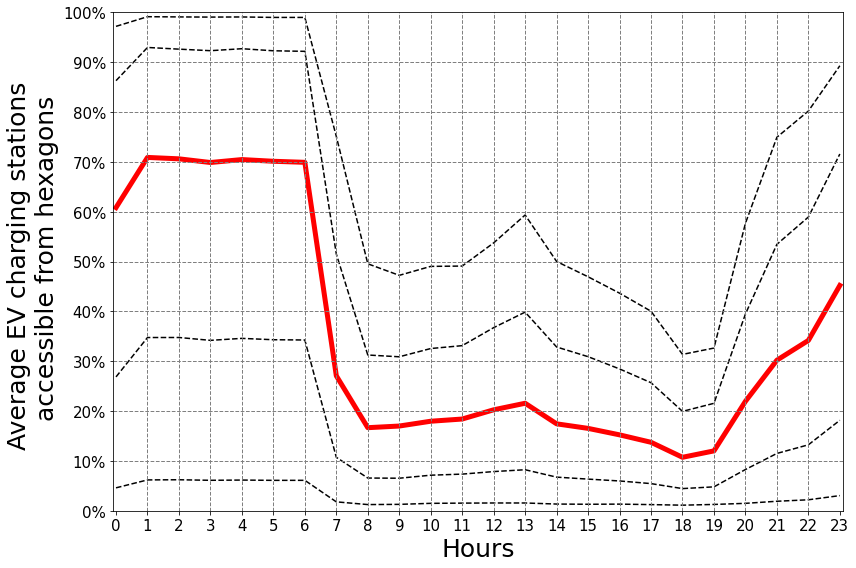

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
line_style = ['--', '--', '-', '--', '--']
line_colors = ['black', 'black', 'red', 'black', 'black']
for idx, minutes in enumerate([5, 10, 15, 20, 25]):
    ax.plot(range(0, 24), percent_accessible_supply.loc[f't_{minutes}'].values, line_style[idx], linewidth=1.5, color=line_colors[idx], label=f'{minutes} Minutes')
    
ax.plot(range(0, 24), percent_accessible_supply.loc[f't_15'].values, '-', linewidth=5, color='red')

for y in range(0, 10, 1):
    plt.axhline(y=y/10, linewidth='1', linestyle='dashed', color='grey')
    
for x in range(1, 23, 1):
    plt.axvline(x=x, linewidth='1', linestyle='dashed', color='grey')    

plt.legend(loc='upper center', fontsize='xx-large')
ax.set_xlim(-0.1, 23.1)
ax.set_xticks(list(range(0, 24)))
ax.set_xticklabels([f'{qTime}' for qTime in range(24)], fontsize=15)
ax.set_xlabel('Hours', fontsize=25)
ax.set_ylim(0, 1.001)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels([f'{i}%' for i in range(0, 110, 10)], fontsize=15)
ax.set_ylabel(f'Average EV charging stations \n accessible from hexagons', fontsize=25)
ax.get_legend().remove()
plt.tight_layout()
plt.show()

# 2. Accessibilty measurement

In [9]:
def gaussian(dij, d0):  # Gaussian function for distance decay
    if d0 >= dij:
        val = (math.exp(-1 / 2 * ((dij / d0) ** 2)) - math.exp(-1 / 2)) / (1 - math.exp(-1 / 2))
        return val
    else:
        return 0
    
    
def static_G2SFCA_step1(supply, demand, mobility, trvl_time):
    acc_step1 = gpd.GeoDataFrame(index=supply.index, columns=[f'step1'], geometry=supply.geometry)
    
    for s_idx, s_row in tqdm(supply.iterrows(), total=supply.shape[0]):
        step1_ctmt_area = mobility.loc[(mobility['Station_ID'] == s_idx) & 
                                       (mobility[f'MinTravel'] <= trvl_time) & 
                                       (mobility[f'Tra_WD_{qTime}'] != 0)]
        step1_ctmt_area_pop = 0
        for td_idx, td_row in step1_ctmt_area.iterrows():
            temp_demand = demand.at[td_row['GRID_ID'], f'ResidPop']
            step1_ctmt_area_pop += temp_demand * gaussian(td_row[f'MinTravel'], trvl_time)

        if step1_ctmt_area_pop > 0:
            acc_step1.at[s_idx, f'step1'] = s_row['Weight'] / step1_ctmt_area_pop * 10000

        else:
            acc_step1.at[s_idx, f'step1'] = 0.0
    
    return acc_step1


def static_G2SFCA_step2(step1, demand, mobility, trvl_time):
    acc_step2 = gpd.GeoDataFrame(index=demand.index, columns=[f'step2'], geometry=demand.geometry)

    for d_idx, d_row in tqdm(acc_step2.iterrows(), total=acc_step2.shape[0]):
        step2_ctmt_area = mobility.loc[(mobility['GRID_ID'] == d_idx) & 
                                       (mobility[f'MinTravel'] <= trvl_time) & 
                                       (mobility[f'MinTravel'] != 0)]

        summed_ratio = 0
        for ts_idx, ts_row in step2_ctmt_area.iterrows():
            temp_ratio = step1.at[ts_row['Station_ID'], f'step1']
            summed_ratio += temp_ratio * gaussian(ts_row[f'MinTravel'], trvl_time)

        if summed_ratio > 0:
            acc_step2.at[d_idx, f'step2'] = summed_ratio

        else:
            acc_step2.at[d_idx, f'step2'] = 0.0

    acc_step2[f'step2'] = acc_step2[f'step2'].astype(float)

    return acc_step2

    
def dynamic_G2SFCA_step1(supply, demand, mobility, trvl_time, qTime, acc_step1):
    operating_supply = supply.loc[supply[f'Hour_WD_{qTime}'] == 'Y']

    for s_idx, s_row in tqdm(operating_supply.iterrows(), total=operating_supply.shape[0]):
        step1_ctmt_area = mobility.loc[(mobility['Station_ID'] == s_idx) & 
                                       (mobility[f'Tra_WD_{qTime}'] <= trvl_time) & 
                                       (mobility[f'Tra_WD_{qTime}'] != 0)]

        step1_ctmt_area_pop = 0
        for td_idx, td_row in step1_ctmt_area.iterrows():
            temp_demand = demand.at[td_row['GRID_ID'], f'Flo_WD_{qTime}']
            step1_ctmt_area_pop += temp_demand * gaussian(td_row[f'Tra_WD_{qTime}'], trvl_time)

        if step1_ctmt_area_pop > 0:
            acc_step1.at[s_idx, f'step1_{qTime}'] = s_row['Weight'] / step1_ctmt_area_pop * 10000

        else:
            acc_step1.at[s_idx, f'step1_{qTime}'] = 0.0

    return acc_step1


def dynamic_G2SFCA_step2(step1, demand, mobility, trvl_time, qTime, acc_step2):

    for d_idx, d_row in tqdm(acc_step2.iterrows(), total=acc_step2.shape[0]):
        step2_ctmt_area = mobility.loc[(mobility['GRID_ID'] == d_idx) & 
                                       (mobility[f'Tra_WD_{qTime}'] <= trvl_time) & 
                                       (mobility[f'Tra_WD_{qTime}'] != 0)]

        summed_ratio = 0
        for ts_idx, ts_row in step2_ctmt_area.iterrows():
            temp_ratio = step1.at[ts_row['Station_ID'], f'step1_{qTime}']
            summed_ratio += temp_ratio * gaussian(ts_row[f'Tra_WD_{qTime}'], trvl_time)

        if summed_ratio > 0:
            acc_step2.at[d_idx, f'step2_{qTime}'] = summed_ratio

        else:
            acc_step2.at[d_idx, f'step2_{qTime}'] = 0.0

    acc_step2[f'step2_{qTime}'] = acc_step2[f'step2_{qTime}'].astype(float)

    return acc_step2


threshold_trvl_time = 15
# Static Measurements
static_acc_step1 = static_G2SFCA_step1(supply, demand, mobility, threshold_trvl_time)
static_acc_step2 = static_G2SFCA_step2(static_acc_step1, demand, mobility, threshold_trvl_time)
static_acc_step2.to_file(f'./data/static_acc_{threshold_trvl_time}min_JP.shp')

# Dynamic Measurements
dyn_acc_step1 = gpd.GeoDataFrame(index=supply.index, columns=[f'step1_{qTime}' for qTime in range(24)], geometry=supply.geometry)
dyn_acc_step2 = gpd.GeoDataFrame(index=demand.index, columns=[f'step2_{qTime}' for qTime in range(24)], geometry=demand.geometry)

for i in range(24):
    dyn_acc_step1 = dynamic_G2SFCA_step1(supply, demand, mobility, threshold_trvl_time, i, dyn_acc_step1)
    dyn_acc_step1[[f'step1_{i}']] = dyn_acc_step1[[f'step1_{i}']].fillna(0.0)
    dyn_acc_step2 = dynamic_G2SFCA_step2(dyn_acc_step1, demand, mobility, threshold_trvl_time, i, dyn_acc_step2)
    dyn_acc_step2[[f'step2_{i}']] = dyn_acc_step2[[f'step2_{i}']].fillna(0.0)
    
dyn_acc_step2.to_file(f'./data/dynamic_acc_{threshold_trvl_time}min_JP.shp')

100%|██████████| 703/703 [00:09<00:00, 75.56it/s]


Static accessibility to EV charging stations


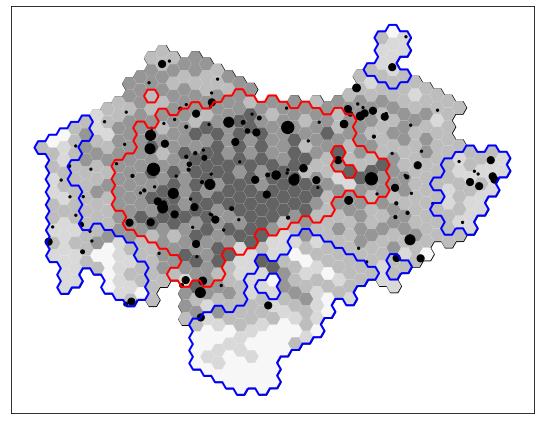

Dynamic (24 hour) accessibility to EV charging stations


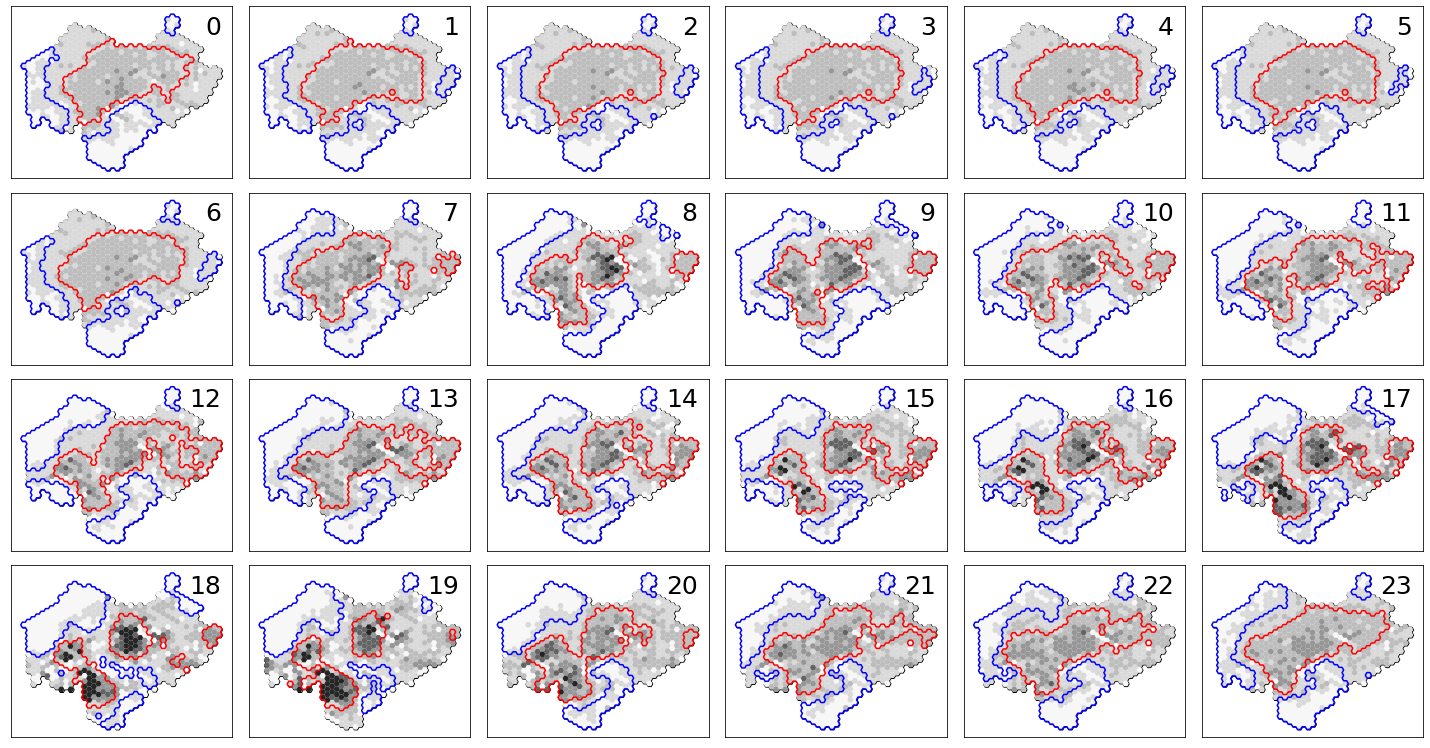

In [10]:
def getis_ord_G_local(gdf, col):
    points = gdf.copy(deep=True)
    points = points.to_crs(epsg=5179)
    points = points.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

    w = libpysal.weights.DistanceBand(list(points), threshold=900)
    if col in gdf.columns:
        y = list(gdf[col].values)
    else:
        y = list(gdf.loc[col].values)
    
    lg = esda.getisord.G_Local(y, w, transform='B')
    
    G_local_result = gpd.GeoDataFrame(data=np.vstack((lg.Zs, lg.p_norm)).T, columns=['G_local', 'p_val'], index=demand.index, geometry=demand.geometry)
    G_local_result['G_coded'] = ''

    for idx, row in G_local_result.iterrows():
        
        if (row['G_local'] < 0) & (row['p_val'] < 0.05):
            G_local_result.at[idx, 'G_coded'] = 'Cold Spot'
        elif (row['G_local'] > 0) & (row['p_val'] < 0.05):
            G_local_result.at[idx, 'G_coded'] = 'Hot Spot'
        else:
            G_local_result.at[idx, 'G_coded'] = 'Not Sig'
    
    G_local_result = G_local_result.dissolve(by='G_coded')
    
    return G_local_result


def plot_dyn_acc(dyn_df, plt_cls, colorBrewer):
    fig = plt.figure(figsize=(20, 10.5))
    
    for qTime in range(24):
        ax = fig.add_subplot(4, 6, qTime + 1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        demand.dissolve(by='dummy').plot(color='#FFFFFF', edgecolor='black', ax=ax)
        
        for idx, cls in enumerate(plt_cls):
            if idx == 0:  
                continue

            temp_dyn = dyn_df.loc[(plt_cls[idx-1] <= dyn_df[f'step2_{qTime}']) & (dyn_df[f'step2_{qTime}'] < cls)]

            if temp_dyn.shape[0] > 0:
                temp_dyn.plot(ax=ax, color=colorBrewer[idx-1])
                
        G_hxg = getis_ord_G_local(dyn_df, f'step2_{qTime}')

        G_hxg.loc[['Cold Spot']].boundary.plot(color='blue', ax=ax)
        G_hxg.loc[['Hot Spot']].boundary.plot(color='red', ax=ax)            
        ax.text(0.95, 0.95, str(qTime), fontsize=25, ha='right', va='top', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()
    
    return dyn_df


def plot_static_acc(static_df, plt_cls, colorBrewer):
    fig = plt.figure(figsize=(8, 6))

    ax = fig.add_subplot(1, 1, 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    demand.dissolve(by='dummy').plot(color='#FFFFFF', edgecolor='black', ax=ax)
    
    for idx, cls in enumerate(plt_cls):
        if idx == 0:  
            continue

        temp_dyn = static_df.loc[(plt_cls[idx-1] <= static_df[f'step2']) & (static_df[f'step2'] < cls)]
        if temp_dyn.shape[0] > 0:
            temp_dyn.plot(ax=ax, color=colorBrewer[idx-1])

    G_hxg = getis_ord_G_local(static_df, 'step2')
    G_hxg.loc[['Cold Spot']].boundary.plot(color='blue', linewidth=2, ax=ax)
    G_hxg.loc[['Hot Spot']].boundary.plot(color='red', linewidth=2, ax=ax)  
    supply.plot(ax=ax, color='black', markersize=supply['Weight']*5)
    plt.tight_layout()
    plt.show()
    
    return static_df


threshold_trvl_time = 15
static_acc = gpd.read_file(f'./data/static_acc_{threshold_trvl_time}min_JP.shp')
static_acc = static_acc.set_index('GRID_ID')
static_acc = static_acc.to_crs(epsg=4326)
dyn_acc = gpd.read_file(f'./data/dynamic_acc_{threshold_trvl_time}min_JP.shp')
dyn_acc = dyn_acc.set_index('GRID_ID')

colorBrewer = ['#f7f7f7', '#d9d9d9', '#bdbdbd', '#969696', '#636363', '#252525']
plt_cls = [0, 2, 4, 6, 8, 10, 100]
print("Static accessibility to EV charging stations")
static_acc = plot_static_acc(static_acc, plt_cls, colorBrewer)

print("Dynamic (24 hour) accessibility to EV charging stations")
dyn_acc = plot_dyn_acc(dyn_acc, plt_cls, colorBrewer)

# 3. Temporal clustering
## 3.1. K-means method

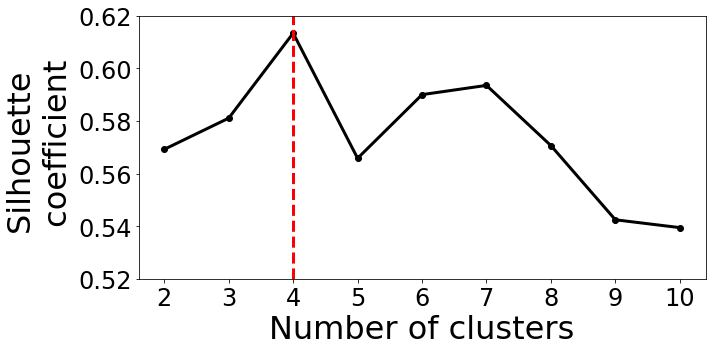

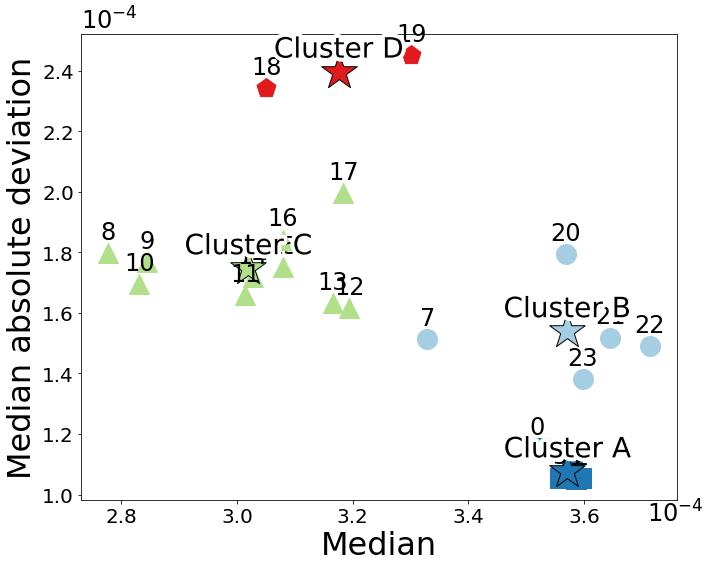

In [11]:
def determine_number_of_cluster(array):
    km_cost = []  # Sum of squared distances of samples to their closest cluster center.
    distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
    km_silhouette = []

    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999)
        KM.fit(array)

        # Calculate Silhouette Scores
        preds = KM.predict(array)
        silhouette = silhouette_score(array, preds)
        km_silhouette.append(silhouette)

    return km_silhouette


def kmeans_cluster(acc_array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster)
    kmeans.fit(acc_array)
    y_kmeans = kmeans.predict(acc_array)
    y_kmeans = np.where(y_kmeans==y_kmeans[3], 'A', y_kmeans)
    y_kmeans = np.where(y_kmeans==y_kmeans[14], 'C', y_kmeans)
    y_kmeans = np.where(y_kmeans==y_kmeans[19], 'D', y_kmeans)
    y_kmeans = np.where(y_kmeans==y_kmeans[22], 'B', y_kmeans)
    
    cluster_result = pd.DataFrame({'Hour': range(0, 24), 'Cluster': y_kmeans, 'median': acc_array[:, 0], 'mad': acc_array[:, 1]})

    return cluster_result


def plot_kmeans(cluster_result, colorBrewer, markerTypes):
    plt.figure(figsize=(10, 8))  # Initiate plot
    ax = plt.gca()

    
    # annotate indivicual points
    for idx, row in cluster_result.iterrows():
        plt.annotate(f"{int(row['Hour'])}",  # this is the text
                     (row['median'], row['mad']),  # this is the point to label
                     textcoords="offset points",  # how to position the text
                     xytext=(0, 14),  # distance from text to points (x,y)
                     ha='center',  # horizontal alignment can be left, right or center
                     size=24)
    
    for cluster_idx, cluster_ltr in enumerate(['A', 'B', 'C', 'D']):
        # plot individual points
        each_cluster = cluster_result.loc[cluster_result['Cluster'] == cluster_ltr]
        each_cluster.plot.scatter('median', 'mad', s=400, c=colorBrewer[cluster_idx], marker=markerTypes[cluster_idx], ax=ax)
        
        # Plot centers of clusters
        temp_mean = each_cluster['median'].mean()
        temp_std = each_cluster['mad'].mean()
        plt.scatter(temp_mean, temp_std, c=colorBrewer[cluster_idx], s=1400, marker='*', edgecolors="black", linewidth=1)
        plt.annotate(f'Cluster {cluster_ltr}',  # this is the text
                 (temp_mean, temp_std),# this is the point to label
                 textcoords="offset points",  # how to position the text,
                 xytext=(0, 14),  # distance from text to points (x,y)
                 ha='center',  # horizontal alignment can be left, right or center
                 size=28,
                 path_effects=[pe.withStroke(linewidth=8, foreground="white")])

    plt.xlabel("Median", fontsize=32)
    plt.ylabel("Median absolute deviation", fontsize=32)
    ax.text(0, 1, '$10^{-4}$', ha='left', va='bottom', transform=ax.transAxes, fontsize=24)
    ax.text(0.95, 0, '$10^{-4}$', ha='left', va='top', transform=ax.transAxes, fontsize=24)

    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.tight_layout()
    plt.show()

    

ratio = pd.DataFrame(index=[f'hour_{i}' for i in range(24)])
for i in range(24):
    ratio.at[f'hour_{i}', f'median_15'] = dyn_acc[f'step2_{i}'].median()
    ratio.at[f'hour_{i}', f'mad_15'] = dyn_acc[f'step2_{i}'].mad()
    
k_means_silhoutte =  determine_number_of_cluster(ratio[[f'median_15', f'mad_15']])

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(range(2, 11), k_means_silhoutte, color='black', linewidth='3', marker='o', linestyle='solid')
plt.axvline(x=4, linewidth='3', linestyle='dashed', color='red')
ax.set_ylabel(f'Silhouette \n coefficient', rotation='vertical', fontsize=32)
ax.set_xlabel('Number of clusters', fontsize=32)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(0.52, 0.62)
plt.tight_layout()
plt.show()

colorBrewer = ['#1f78b4', '#a6cee3', '#b2df8a', '#e31a1c'] 
markerTypes = ['s', 'o', '^', 'p']


cluster_result = kmeans_cluster(ratio[[f'median_15', f'mad_15']].to_numpy(), 4)
plot_kmeans(cluster_result, colorBrewer, markerTypes)

## 3.2. Hierarchical clustering
### 3.2.1. Determine Optimal Number of Clusters

2 0.3806 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
3 0.4298 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 1 0 0 0]
4 0.4175 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 3 3 2 1 1 1]
5 0.4335 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3 4 4 3 1 1 1]
6 0.4354 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3 4 4 5 1 1 1]
7 0.4225 [0 0 0 0 0 0 0 1 2 2 2 3 3 3 3 4 4 4 5 5 6 1 1 1]
8 0.3966 [0 0 0 0 0 0 0 1 2 2 2 3 3 3 3 4 4 4 5 6 7 1 1 1]
9 0.3894 [0 0 0 0 0 0 0 1 2 2 2 3 3 3 3 4 4 4 5 6 7 8 8 8]
10 0.3817 [0 0 0 0 0 0 0 1 2 2 2 3 3 3 3 4 4 5 6 7 8 9 9 9]


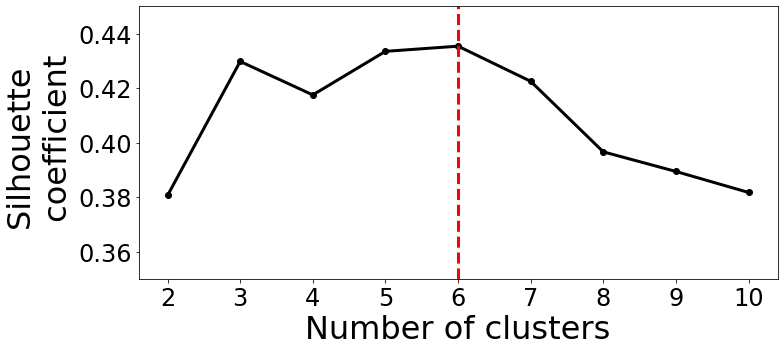

In [12]:
threshold_trvl_time = 15
dyn_acc = dyn_acc[[f'step2_{i}' for i in range(24)]]
dyn_acc = dyn_acc.transpose()

fig, ax = plt.subplots(figsize=(11,5))

list_silhouette = []
for i in range(2, 11):
    cluster_labels = hierarchy.cut_tree(hierarchy.ward(dyn_acc), n_clusters=i).T[0]
    list_silhouette.append(round(silhouette_score(dyn_acc, cluster_labels), 4))
    print(i, round(silhouette_score(dyn_acc, cluster_labels), 4), cluster_labels)
    
plt.plot(range(2, 11), list_silhouette, color='black', linewidth='3', marker='o', linestyle='solid')
plt.axvline(x=6, linewidth='3', linestyle='dashed', color='red')
ax.set_ylabel(f'Silhouette \n coefficient', rotation='vertical', fontsize=32)
ax.set_xlabel('Number of clusters', fontsize=32)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(0.35, 0.45)
plt.tight_layout()
plt.show()

### 3.2.2. Conduct hierarchical clustering

In [13]:
num_of_clusters = 6
cluster_labels = hierarchy.cut_tree(hierarchy.ward(dyn_acc), n_clusters=num_of_clusters)
cluster_labels = np.where(cluster_labels==cluster_labels[2], 'A', cluster_labels)
cluster_labels = np.where(cluster_labels==cluster_labels[22], 'B', cluster_labels)
cluster_labels = np.where(cluster_labels==cluster_labels[12], 'C', cluster_labels)
cluster_labels = np.where(cluster_labels==cluster_labels[16], 'D', cluster_labels)
cluster_labels = np.where(cluster_labels==cluster_labels[20], 'F', cluster_labels)
cluster_labels = np.where(cluster_labels==cluster_labels[18], 'E', cluster_labels)
cluster_labels = cluster_labels.T[0]

cluster_labels = pd.DataFrame(data=np.vstack((np.array(range(24)), cluster_labels)).T, columns=['hour', 'label'])
cluster_labels

,hour,label
0,0,A
1,1,A
2,2,A
3,3,A
4,4,A
5,5,A
6,6,A
7,7,B
8,8,C
9,9,C


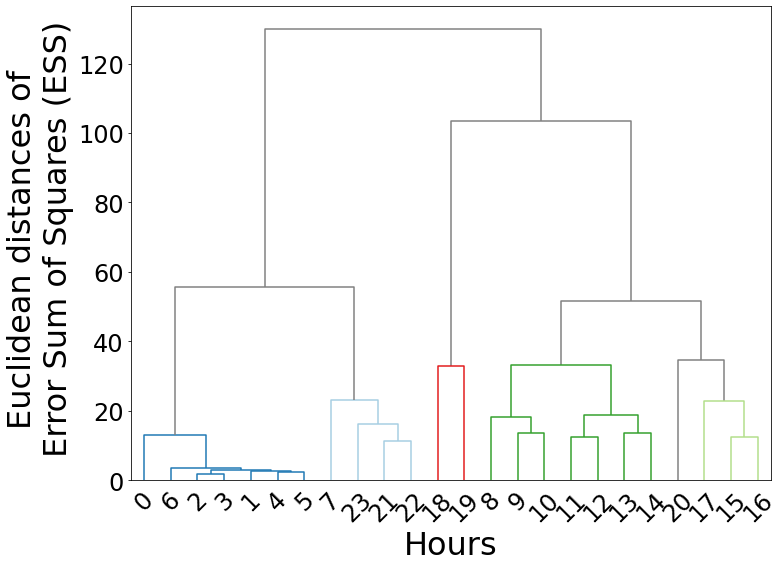

In [14]:
colorBrewer = {'A': '#1f78b4', 'B': '#a6cee3', 'E': '#e31a1c', 'C': '#33a02c', 'D': '#b2df8a', 'F': '#fb9a99'}

Z = hierarchy.linkage(dyn_acc, 'ward')
dn = hierarchy.dendrogram(Z=Z, labels=dyn_acc.index.to_list(), no_plot=True)

D_leaf_colors = {}
for leaf_idx in dn['leaves']:
    leaf_cluster = cluster_labels.loc[leaf_idx, 'label']
    D_leaf_colors[leaf_idx] = colorBrewer[leaf_cluster]

dflt_col = "#808080" 
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(Z) else D_leaf_colors[x] for x in i12)
    link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col

fig, ax = plt.subplots(figsize=(11,8))
# fig, ax = plt.subplots(figsize=(12,10))
D = hierarchy.dendrogram(Z=Z, link_color_func=lambda x: link_cols[x], ax=ax)
ax.set_ylabel(f'Euclidean distances of \n Error Sum of Squares (ESS)', rotation='vertical', fontsize=32)
ax.set_xlabel('Hours', fontsize=32)
plt.xticks(fontsize=24, rotation=45)
plt.yticks(fontsize=24)

plt.tight_layout()
plt.show()

## 3.3. Clustering results

In [15]:
clusters = gpd.GeoDataFrame(index=dyn_acc.columns, geometry=demand.geometry)
for cluster_label in cluster_labels['label'].unique():
    
    if cluster_label == 'B':
        clustered_hours = [7, 20, 21, 22, 23]
    elif cluster_label == 'F':
        continue
    else:
        clustered_hours = np.where(cluster_labels == cluster_label)[0]
    
    print(cluster_label, clustered_hours)
    clusters[f'cluster_{cluster_label}'] = dyn_acc.apply(lambda x:x[[f'step2_{i}' for i in clustered_hours]].mean())
    
clusters = clusters[['cluster_A', 'cluster_B', 'cluster_C', 'cluster_D', 'cluster_E', 'geometry']]
clusters['static'] = static_acc['step2']
clusters

A [0 1 2 3 4 5 6]
B [7, 20, 21, 22, 23]
C [ 8  9 10 11 12 13 14]
D [15 16 17]
E [18 19]


,cluster_A,cluster_B,cluster_C,cluster_D,cluster_E,geometry,static
GRID_ID,,,,,,,
BR-71,0.624965,1.130595,1.205850,1.685180,2.595756,"POLYGON ((127.06100 37.43028, 127.05959 37.428...",0.986563
BT-71,0.482972,0.117388,0.000000,0.000000,0.000000,"POLYGON ((127.06947 37.43031, 127.06807 37.428...",0.892418
BP-70,0.260995,0.052114,0.000000,0.000000,0.000000,"POLYGON ((127.05250 37.43415, 127.05109 37.432...",0.599535
BQ-70,0.444657,0.913440,0.820105,1.257436,1.963963,"POLYGON ((127.05675 37.43222, 127.05534 37.430...",0.677367
BR-70,0.624965,1.130595,1.205850,1.685180,2.595756,"POLYGON ((127.06097 37.43418, 127.05957 37.432...",0.986563
...,...,...,...,...,...,...,...
CF-44,1.587714,1.598102,1.122780,1.107404,1.470812,"POLYGON ((127.11980 37.53587, 127.11840 37.533...",2.499068
CG-44,2.475607,2.023380,1.337032,1.279503,1.610897,"POLYGON ((127.12406 37.53393, 127.12265 37.531...",3.717192
CE-43,2.660404,2.463269,0.689088,0.939024,0.659779,"POLYGON ((127.11555 37.53780, 127.11414 37.535...",4.072515


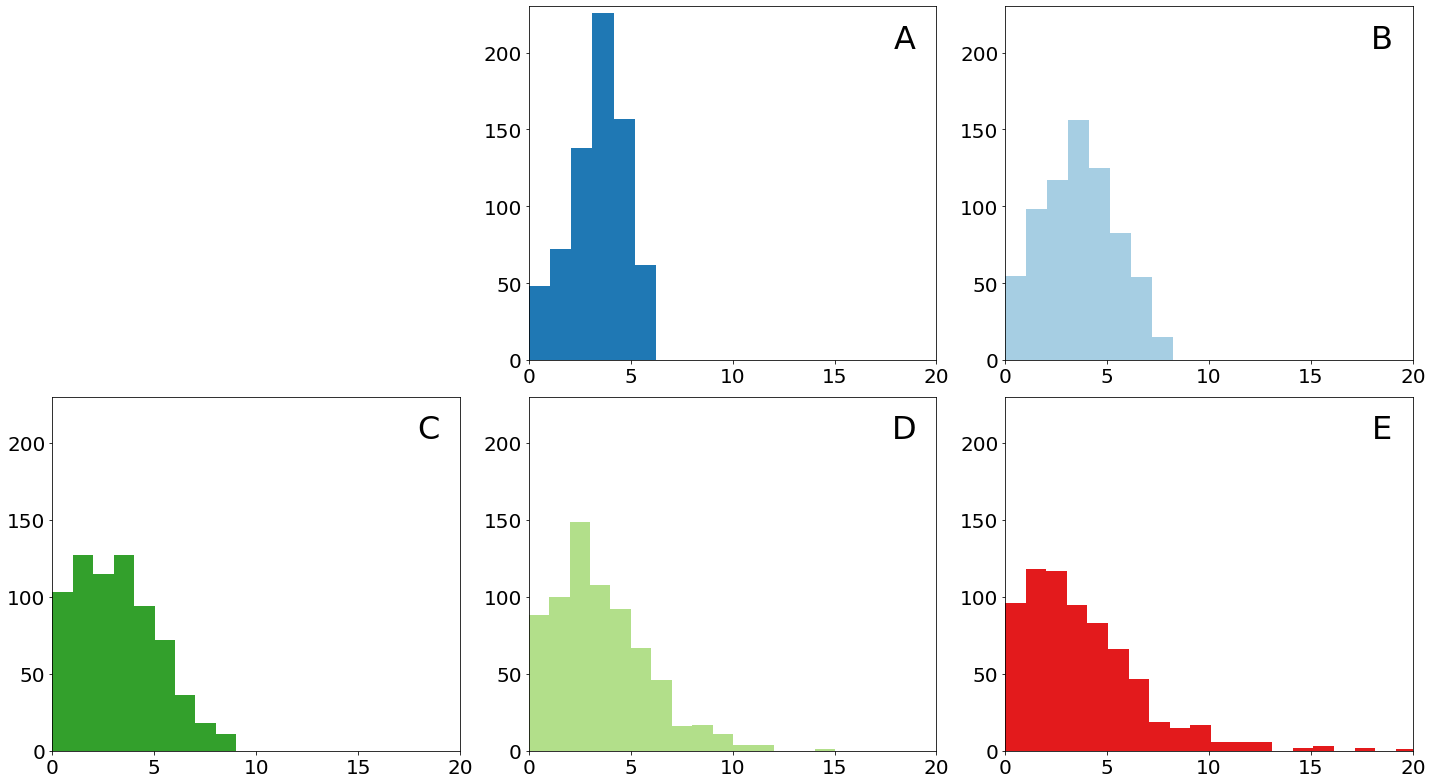

In [16]:
def plot_hist_cluster(cluster_df, cluster_ltrs, colorBrewer):
    fig = plt.figure(figsize=(20, 11))
    
    # cluster histogram
    for cluster_idx, cluster_ltr in enumerate(cluster_ltrs, start=2):
        ax = plt.subplot(2, 3, cluster_idx)
        ax.set_xlim(0, 20)
        ax.set_ylim(top=230)
        
        bins = int(round((cluster_df[f'cluster_{cluster_ltr}'].max() - cluster_df[f'cluster_{cluster_ltr}'].min()) / 1, 0))
        cluster_df[f'cluster_{cluster_ltr}'].hist(grid=False, color=colorBrewer[cluster_ltr], bins=bins)

        ax.set_xticks([0, 5, 10, 15, 20])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        ax.set_yticks([0, 50, 100, 150, 200])
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.text(0.95, 0.95, cluster_ltr, fontsize=32, ha='right', va='top', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

plot_hist_cluster(clusters, ['A', 'B', 'C', 'D', 'E'], colorBrewer)

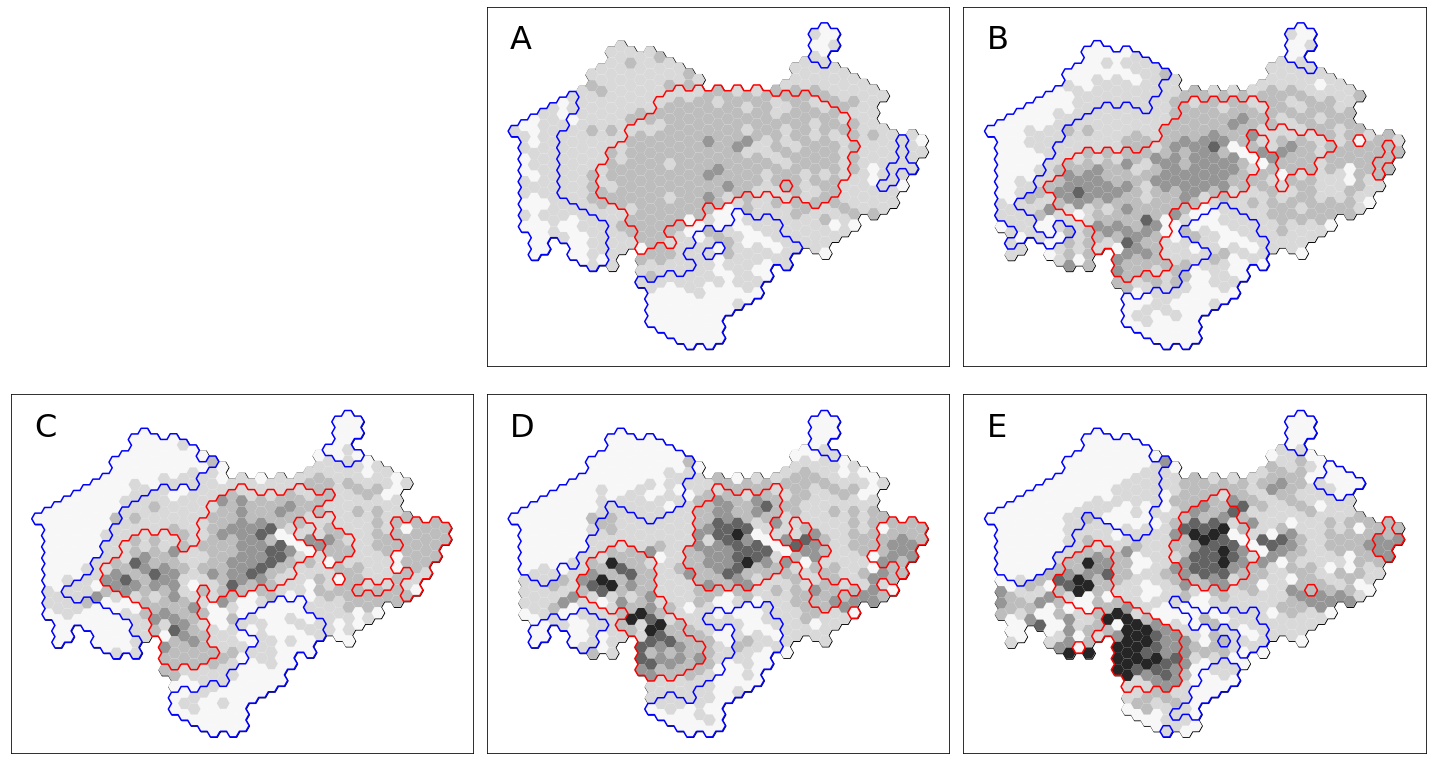

In [17]:
colorBrewer_map = ['#f7f7f7', '#d9d9d9', '#bdbdbd', '#969696', '#636363', '#252525']
plt_cls = [0, 2, 4, 6, 8, 10, 100]

fig = plt.figure(figsize=(20, 11))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for cluster_idx, cluster_ltr in enumerate(['A', 'B', 'C', 'D', 'E'], start=2):       
    ax = fig.add_subplot(2, 3, cluster_idx) 
    demand.dissolve(by='dummy').plot(color='#FFFFFF', edgecolor='black', ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.05, 0.95, cluster_ltr, fontsize=32, ha='left', va='top', transform=ax.transAxes)
    
    for idx, cls in enumerate(plt_cls):
        if idx == 0:  
            continue

        temp_cluster = clusters.loc[(plt_cls[idx-1] <= clusters[f'cluster_{cluster_ltr}']) & (clusters[f'cluster_{cluster_ltr}'] < cls)]
        if temp_cluster.shape[0] > 0:
            temp_cluster.plot(ax=ax, color=colorBrewer_map[idx-1])

    G_hxg = getis_ord_G_local(clusters, f'cluster_{cluster_ltr}')

    G_hxg.loc[['Cold Spot']].boundary.plot(color='blue', ax=ax)
    G_hxg.loc[['Hot Spot']].boundary.plot(color='red', ax=ax)

plt.tight_layout()
plt.show()


# 4. Validation

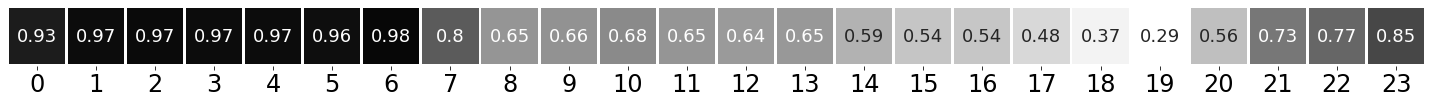

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
dynamic,0.934,0.97,0.973,0.972,0.97,0.965,0.981,0.802,0.652,0.659,...,0.588,0.539,0.535,0.479,0.369,0.294,0.555,0.727,0.772,0.846


In [18]:
valid_dynamic = pd.DataFrame(index=[f'{i}' for i in range(24)])

for i in range(24):
    corr = static_acc[['step2']].corrwith(dyn_acc.loc[f'step2_{i}'], method='pearson')
    valid_dynamic.at[f'{i}', f'dynamic'] = round(corr.values[0], 3)

valid_dynamic = valid_dynamic.fillna(0.0)
valid_dynamic = valid_dynamic.transpose()

fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(valid_dynamic, cmap='Greys', square=True, vmin=0.3, vmax=1, ax=ax, linewidths=2, cbar=False, annot=True, annot_kws={"fontsize":18})
ax.get_yaxis().set_visible(False)
plt.xticks(fontsize=24)
plt.tight_layout()
plt.show()

valid_dynamic

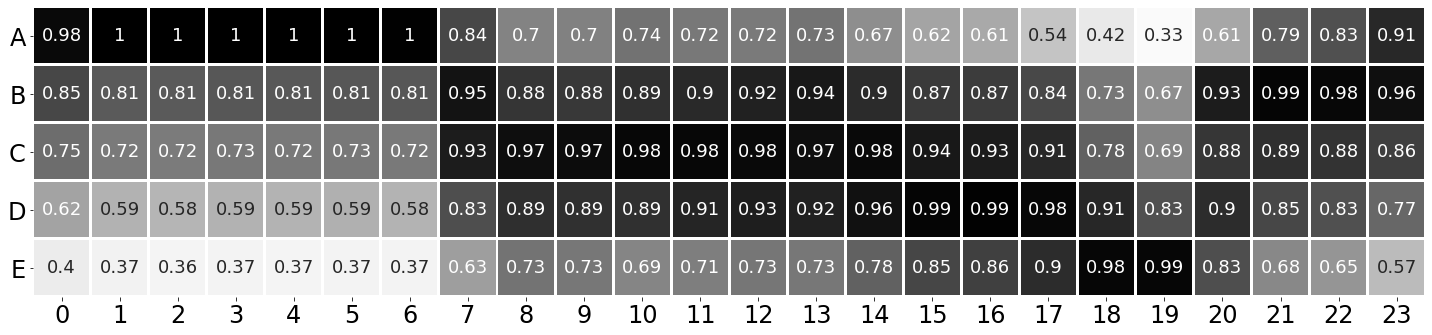

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cluster_A,0.976,0.998,0.998,0.999,0.998,0.998,0.997,0.845,0.698,0.704,...,0.671,0.618,0.607,0.543,0.416,0.329,0.614,0.791,0.828,0.906
cluster_B,0.846,0.805,0.805,0.811,0.806,0.811,0.811,0.954,0.881,0.876,...,0.901,0.870,0.868,0.844,0.728,0.670,0.933,0.988,0.981,0.963
cluster_C,0.752,0.720,0.718,0.726,0.722,0.726,0.722,0.932,0.966,0.970,...,0.977,0.940,0.932,0.906,0.784,0.695,0.879,0.893,0.883,0.861
cluster_D,0.620,0.589,0.581,0.588,0.587,0.592,0.585,0.831,0.891,0.890,...,0.958,0.988,0.992,0.983,0.908,0.829,0.898,0.846,0.828,0.770
cluster_E,0.402,0.374,0.363,0.370,0.367,0.371,0.371,0.632,0.735,0.727,...,0.784,0.848,0.860,0.897,0.984,0.986,0.833,0.683,0.652,0.566


In [19]:
valid_cluster = pd.DataFrame(index=[f'{i}' for i in range(24)])

for cluster_idx, cluster_ltr in enumerate(['A', 'B', 'C', 'D', 'E'], start=1):
    for i in range(24):
        corr = clusters[[f'cluster_{cluster_ltr}']].corrwith(dyn_acc.loc[f'step2_{i}'], method='pearson')
        valid_cluster.at[f'{i}', f'cluster_{cluster_ltr}'] = round(corr.values[0], 3)
valid_cluster = valid_cluster.fillna(0.0)
valid_cluster = valid_cluster.transpose()

fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(valid_cluster, cmap='Greys', square=True, vmin=0.3, vmax=1, ax=ax, yticklabels=['A', 'B', 'C', 'D', 'E'],
            linewidths=2, cbar=False, annot=True, annot_kws={"fontsize":18})
plt.xticks(fontsize=24)
plt.yticks(fontsize=24, rotation=0)
plt.tight_layout()
plt.show()

valid_cluster